In [46]:
#libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [7]:
#constants
nsamp = 50
dim = 2

In [23]:
#generate data
c0mean = np.ones(dim)
c0cov = 0.5 * np.eye(dim)

c0_samples = np.random.multivariate_normal(c0mean, c0cov, nsamp)
c0_y = np.zeros(nsamp)

c1mean = -1 * np.ones(dim)
c1cov = 0.2 * np.eye(dim)

c1_samples = np.random.multivariate_normal(c1mean, c1cov, nsamp)
c1_y = np.ones(nsamp)

In [109]:
#define objective function, stack data for computation
x = np.column_stack((np.ones(nsamp*2), np.vstack([c0_samples, c1_samples])))
y = np.hstack([c0_y, c1_y])
def loss(w):
    loss = y.T @ np.log(1 + np.exp(-w @ x.T)) + (1 - y).T @ np.log(1 + np.exp(w @ x.T))
    return loss

In [110]:
#minimize NLL 
res = minimize(loss, [0,0,0], method='BFGS', options={'disp': True})
w = res.x

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 28
         Function evaluations: 116
         Gradient evaluations: 29


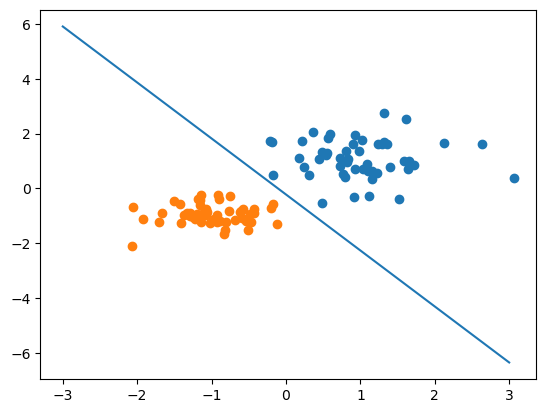

In [92]:
#plot stuff
plt.scatter(c0_samples[:,0], c0_samples[:,1])
plt.scatter(c1_samples[:,0], c1_samples[:,1])
plt.plot(xvalues, -(w[0] + w[1] * xvalues) / w[2])

In [171]:
#gbf function
def gbf(x, mean, s, axis):
    value = np.exp(-(1 / 2 * s**2) * np.sum((x - mean)**2, axis))
    return value

In [172]:
#define objective function, stack data for computation
m = np.vstack([c0_samples, c1_samples])
xg = np.column_stack((np.ones(nsamp*2), gbf(m,[-1,1],0.5,1), gbf(m, [0,0],0.5,1), gbf(m, [1,-1],0.5,1)))
yg = np.hstack([c0_y, c1_y])
def loss_gaussian(wg):
    NLL = yg.T @ np.log(1 + np.exp(-wg @ xg.T)) + (1 - yg).T @ np.log(1 + np.exp(wg @ xg.T))
    return NLL

In [173]:
#minimize NLL 
res_g = minimize(loss_gaussian, np.zeros(4), method='BFGS', options={'disp': True})
wg = res_g.x

Optimization terminated successfully.
         Current function value: 62.209392
         Iterations: 22
         Function evaluations: 125
         Gradient evaluations: 25


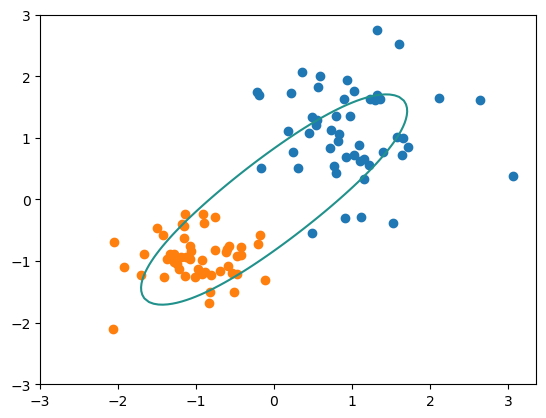

In [174]:
#plot stuff
plt.scatter(c0_samples[:,0], c0_samples[:,1])
plt.scatter(c1_samples[:,0], c1_samples[:,1])
xvalues = np.linspace(-3,3,100)
x1,x2 = np.meshgrid(xvalues, xvalues)
xg = np.stack((x1,x2)).T
Z = wg[0] + wg[1]*gbf(xg,[-1,1],0.5,2) + wg[2]*gbf(xg, [0,0],0.5,2) + wg[3]*gbf(xg, [1,-1],0.5,2)
plt.contour(x1,x2,Z,0)
#plt.plot(xvalues, -(w[0] + w[1] * xvalues) / w[2])

array([[-0.97563737, -0.96456289, -0.95455679, ..., -8.23367074,
        -8.10172945, -7.96471083],
       [-0.96464185, -0.95178899, -0.93993717, ..., -8.37320772,
        -8.24010599, -8.10172945],
       [-0.95472183, -0.94002348, -0.92625129, ..., -8.50727027,
        -8.37320772, -8.23367074],
       ...,
       [-8.24488339, -8.38474019, -8.51912013, ..., -0.92625129,
        -0.93993717, -0.95455679],
       [-8.11264058, -8.25132894, -8.38474019, ..., -0.94002348,
        -0.95178899, -0.96456289],
       [-7.97531824, -8.11264058, -8.24488339, ..., -0.95472183,
        -0.96464185, -0.97563737]])

(100, 100, 2)